# Part 6: Data-driven model of battery with SINDy

SINDy stands for Sparse identification of nonlinear dynamics. Unlike DMDc-type methods, where we sought a linear system approximation to the dynamics, with SINDy we seek a non linear system. In this tutorial, we see how to create a simple SINDy system and transfer it to Collimator.

## Dataset
We utilise the same dataset as in the previous tutorial. We also resample the dataset at a frequency of 10Hz.

## SINDy

Through SINDy, we will seek a battery model of the following form:

\begin{align}
v_t[k+1] &= f(v_t[k],  d[k], i[k]) \\[10pt]
d[k+1] &= g(v_t[k],  d[k], i[k]),
\end{align}

where $f$ and $g$ are nonlinear functions, whose form will be deduced by the SINDy algorithm from a family of functions.

Note: With SINDy one may also seek a continuous-time model for the dynamics. However, continuing the the thread of discrete-time models that we created with DMDc, we only demonstrate discrete-time SINDy model here.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

from math import ceil

from jax import config

config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

from scipy.io import loadmat

train_file_name = "dataset_25deg/10-28-18_17.44 551_UDDS_25degC_LGHG2.mat"
val_file_name = "dataset_25deg/10-29-18_14.41 551_Mixed1_25degC_LGHG2.mat"

tain_data = loadmat(train_file_name)
val_data = loadmat(val_file_name)

Q = 3.0  # battery capacity is known to be 3Ah (LG HG2 cell)


def extract_features_from_matfile(filename, Q=3.0, dt=0.1):
    data = loadmat(filename)
    t = data["meas"][0][0][0]
    vt = data["meas"][0][0][2]
    curr = -data["meas"][0][0][3]
    D = -data["meas"][0][0][4]

    # Resample
    T_end = t[-1, 0]
    t_resampled = np.linspace(0.0, T_end, ceil(T_end / dt))
    vt_resampled = np.interp(t_resampled, t[:, 0], vt[:, 0])
    curr_resampled = np.interp(t_resampled, t[:, 0], curr[:, 0])
    D_resampled = np.interp(t_resampled, t[:, 0], D[:, 0])

    return (t_resampled, vt_resampled, curr_resampled, D_resampled)


t_train, vt_train, curr_train, d_train = extract_features_from_matfile(train_file_name)
t_val, vt_val, curr_val, d_val = extract_features_from_matfile(val_file_name)

We utilise the `pysindy` package for SINDYc with control.

In [2]:
import pysindy as ps

state_names = ["$v_t$", "$d$"]
state_data = np.vstack([vt_train, d_train]).T
control_data = curr_train.reshape((curr_train.size, 1))

optimizer = ps.STLSQ(threshold=1e-05, alpha=0.1, max_iter=500, normalize_columns=True)
degree = 2
poly_library = ps.PolynomialLibrary(degree=degree)
library = poly_library
model = ps.SINDy(
    optimizer=optimizer,
    feature_library=library,
    feature_names=["v", "d", "i"],
    discrete_time=True,
)

model.fit(state_data, u=control_data)
model.print(precision=6)

(v)[k+1] = -0.479340 1 + 1.258183 v[k] + 0.055073 d[k] + 0.005494 i[k] + -0.034365 v[k]^2 + -0.015189 v[k] d[k] + -0.001495 v[k] i[k] + -0.001704 d[k]^2 + -0.000314 d[k] i[k] + -0.000019 i[k]^2
(d)[k+1] = 0.000963 1 + -0.000482 v[k] + 0.999856 d[k] + 0.000015 i[k] + 0.000060 v[k]^2 + 0.000036 v[k] d[k] + 0.000003 v[k] i[k] + 0.000006 d[k]^2 + 0.000001 d[k] i[k]


We can now simulate the model, initialising the model at the initial values of the state measurements, and see how its predictions compare with the experiment data.

RMS: error: [0.03110798189747098, 0.0016590303470951815]


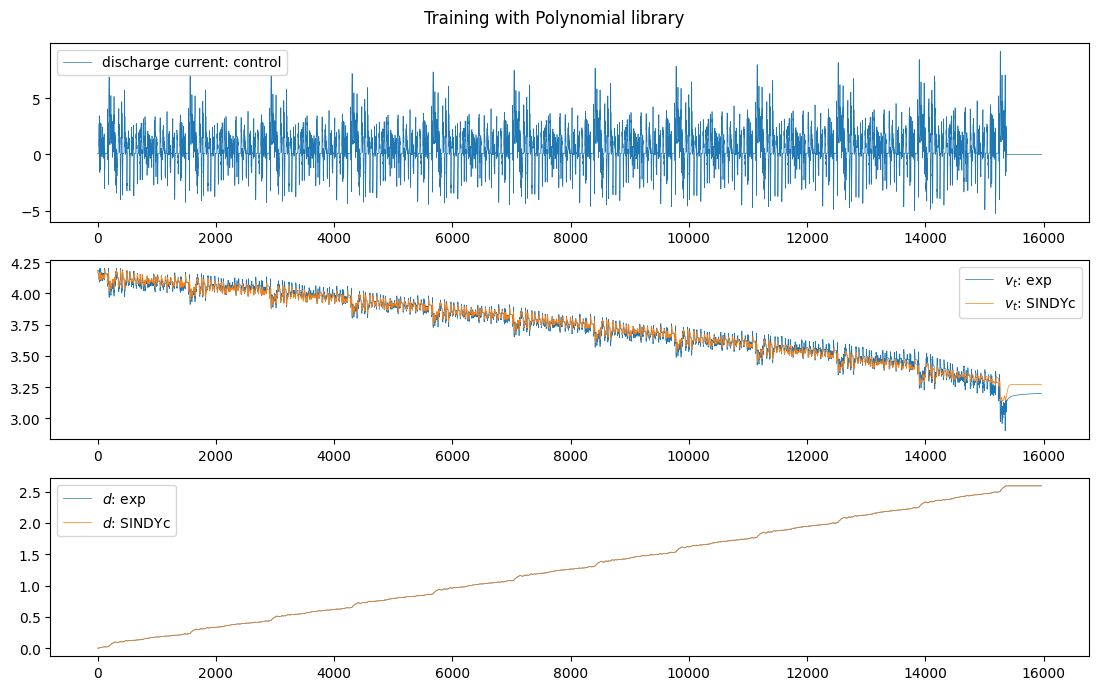

In [3]:
initial_state = state_data[0, :].reshape((1, state_data.shape[1]))

n_steps = state_data.shape[0] - 1
lw = 0.5
pred_state = model.simulate(initial_state, u=control_data[:-1], t=n_steps)
pred_state = np.vstack([initial_state, pred_state])


def compute_prediction_error(pred_state, state_data):
    rms_err = []
    for y, x in zip(pred_state.T, state_data.T):
        rms_err.append(np.sqrt(np.average((y - x) ** 2)))
    return rms_err


print("RMS: error:", compute_prediction_error(pred_state, state_data))

fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(t_train, control_data[:, 0], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[:, i], label=state_names[i] + ": exp", lw=lw)
    ax.plot(t_train, pred_state[:, i], label=state_names[i] + ": SINDYc", lw=lw)
    ax.legend(loc="best")
fig.suptitle("Training with Polynomial library")
plt.tight_layout()
plt.show()

## Augmenting SINDyc model
The above model is reasonably good. However, increasing the degree of polynomials in the feature library does not lead to any further improvement. We can augment the system with some of our own basis functions and see if we get any improvements.

In [4]:
from pysindy.feature_library import CustomLibrary, GeneralizedLibrary

# our own augmented basis functions
functions = [
    lambda x: np.exp(-0.5 / (x + 1e-06) ** 2),
    lambda x: 1.0 / (x + 1e-06),
]  # 1e06 eliminates divide by zero.
custom_library = CustomLibrary(library_functions=functions)
library = GeneralizedLibrary([poly_library, custom_library])

model = ps.SINDy(
    optimizer=optimizer,
    feature_library=library,
    feature_names=["v", "d", "i"],
    discrete_time=True,
)

model.fit(state_data, u=control_data)
model.print(precision=6)
# In the output, our custom functions are denoted as f0 and f1.

(v)[k+1] = -38.783301 1 + 1.649871 v[k] + -0.076353 d[k] + -0.002126 i[k] + -0.032939 v[k]^2 + 0.016700 v[k] d[k] + 0.000248 v[k] i[k] + 0.002367 d[k]^2 + 0.000322 d[k] i[k] + 0.000008 i[k]^2 + 33.971585 f0(v[k]) + -0.006178 f0(d[k]) + -0.000314 f0(i[k]) + 15.162132 f1(v[k])
(d)[k+1] = -0.020689 1 + 0.000450 v[k] + 0.999905 d[k] + 0.000019 i[k] + -0.000012 v[k]^2 + 0.000024 v[k] d[k] + 0.000002 v[k] i[k] + 0.000004 d[k]^2 + 0.000001 d[k] i[k] + 0.017209 f0(v[k]) + 0.000005 f0(d[k]) + 0.009575 f1(v[k])


RMS: error: [0.020883891447994487, 0.0010211349601141572]


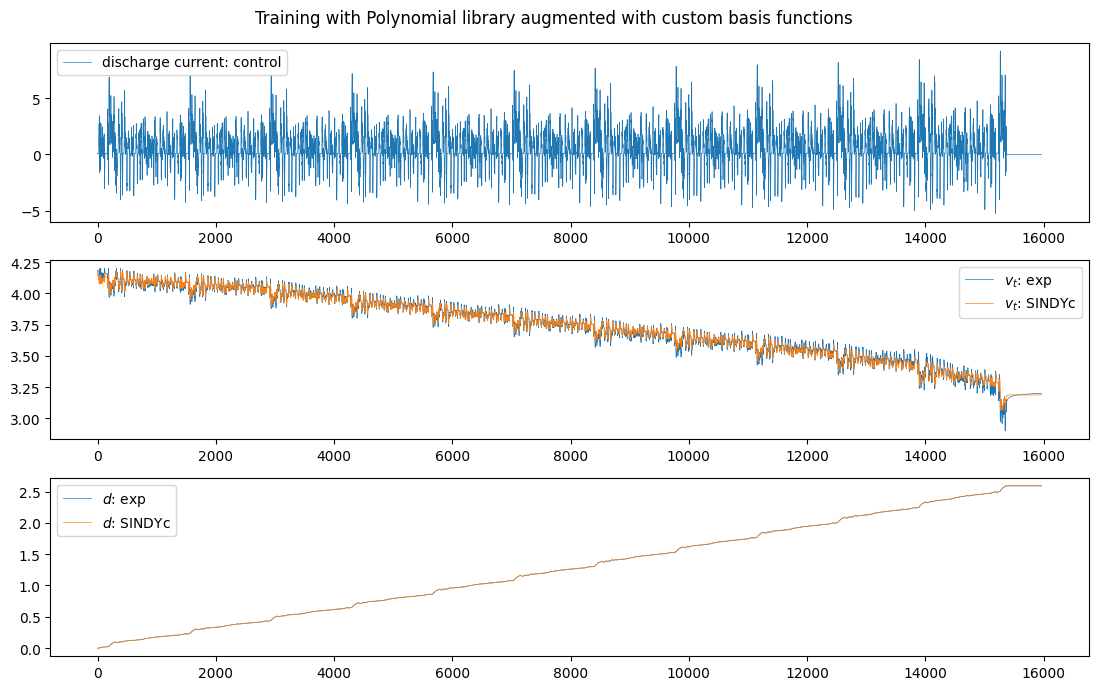

In [5]:
initial_state = state_data[0, :].reshape((1, state_data.shape[1]))

n_steps = state_data.shape[0] - 1
lw = 0.5
pred_state = model.simulate(initial_state, u=control_data[:-1], t=n_steps)
pred_state = np.vstack([initial_state, pred_state])


def compute_prediction_error(pred_state, state_data):
    rms_err = []
    for y, x in zip(pred_state.T, state_data.T):
        rms_err.append(np.sqrt(np.average((y - x) ** 2)))
    return rms_err


print("RMS: error:", compute_prediction_error(pred_state, state_data))

fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(t_train, control_data[:, 0], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[:, i], label=state_names[i] + ": exp", lw=lw)
    ax.plot(t_train, pred_state[:, i], label=state_names[i] + ": SINDYc", lw=lw)
    ax.legend(loc="best")
fig.suptitle("Training with Polynomial library augmented with custom basis functions")
plt.tight_layout()
plt.show()

### Validation

We can run the model on unseen data to validate its predictive power.

RMS: error: [0.03653665408548043, 0.002789606097449365]


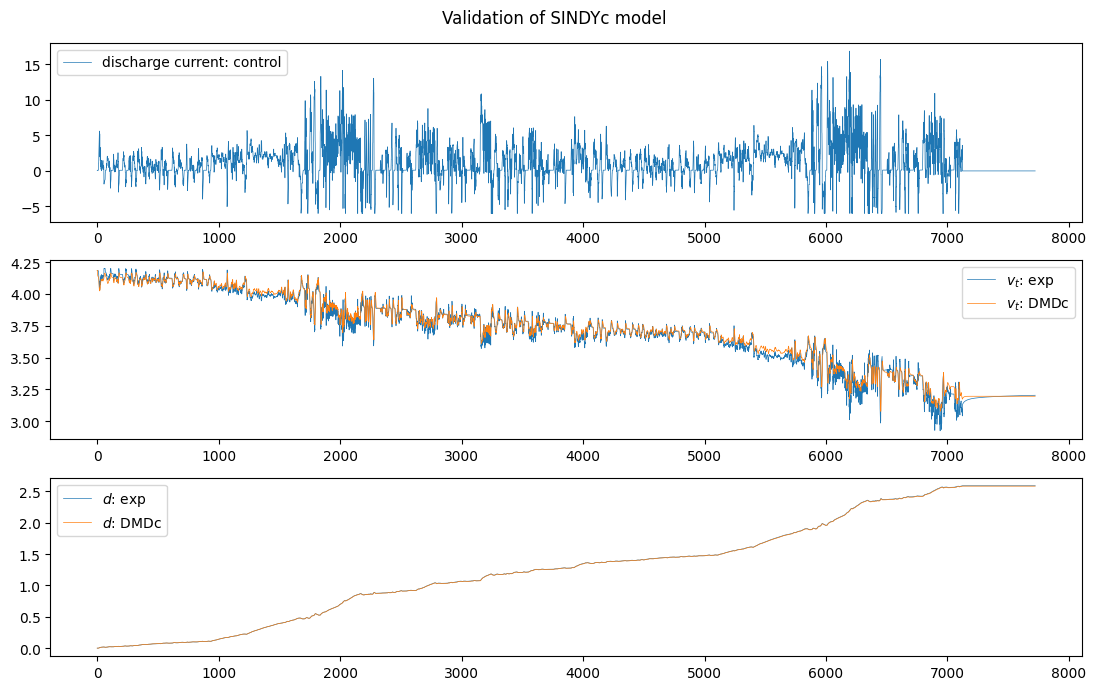

In [6]:
state_data = np.vstack([vt_val, d_val]).T
control_data = curr_val.reshape((curr_val.size, 1))

initial_state = state_data[0, :].reshape((1, state_data.shape[1]))
n_steps = state_data.shape[0] - 1
lw = 0.5
pred_state = model.simulate(initial_state, u=control_data[:-1], t=n_steps)
pred_state = np.vstack([initial_state, pred_state])

print("RMS: error:", compute_prediction_error(pred_state, state_data))

fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(t_val, control_data[:, 0], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_val, state_data[:, i], label=state_names[i] + ": exp", lw=lw)
    ax.plot(t_val, pred_state[:, i], label=state_names[i] + ": DMDc", lw=lw)
    ax.legend(loc="best")
fig.suptitle("Validation of SINDYc model")
plt.tight_layout()
plt.show()

## Including the SINDYc model in Collimator

To included the extended SINDYc model in Collimator, we can modify the `ExtendedDiscreteLinearSystem` to the `SindyDiscreteLinearSystem` by passing the SINDYc model object, and leverage its structure to create an appropriate state update function. Let's first investigate the trainded SINDYc model.

In [7]:
print(model.get_feature_names())
print(len(model.get_feature_names()))

['1', 'v', 'd', 'i', 'v^2', 'v d', 'v i', 'd^2', 'd i', 'i^2', 'f0(v)', 'f0(d)', 'f0(i)', 'f1(v)', 'f1(d)', 'f1(i)']
16


These features represent all the basis functions used in the SINDyc model. Recall that `f0` and `f1` are the custom functions we defined. Next, let's see the trained coefficients in the SINDYc model.

In [8]:
print(model.coefficients())
print(model.coefficients().shape)

[[-3.87833007e+01  1.64987099e+00 -7.63526570e-02 -2.12601052e-03
  -3.29389405e-02  1.66999188e-02  2.48272074e-04  2.36689582e-03
   3.21891502e-04  7.99836889e-06  3.39715849e+01 -6.17801478e-03
  -3.14483759e-04  1.51621317e+01  3.32611985e-09 -7.28895611e-10]
 [-2.06885195e-02  4.50091119e-04  9.99905365e-01  1.88823487e-05
  -1.17644152e-05  2.38938504e-05  2.28124811e-06  4.38653934e-06
   6.09846595e-07  1.58617843e-08  1.72091222e-02  5.21996713e-06
   3.79673806e-07  9.57464173e-03 -1.13195261e-13  4.05257967e-13]]
(2, 16)


So, for each discrete-time updadate, the `model coefficients` need to be matrix multiplied by the `model features`.

To create a Collimator model, one may manually transfer the above equations for the features, or use some sort of a parser. We demonstrate the latter approach using `sympy`.

In [9]:
import collimator
from collimator.framework import LeafSystem
from collimator.library import Constant

from collimator.simulation import SimulatorOptions, ODESolverOptions

import sympy as sp

from typing import NamedTuple

# import numpy as np


class SindyDiscreteLinearSystem(LeafSystem):
    """
    System for discrete Sindy model
    """

    def __init__(self, model, dt, initial_state, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Sympy parsing to evaluate the features
        # Only tested for polynomial library of degree 2 and the current custom functions

        # Define the symbols
        v, d, i = sp.symbols("v d i")

        # Define custom Sympy functions (as standalone functions)
        def f0(x):
            return sp.exp(-0.5 / (x + 1e-06) ** 2)

        def f1(x):
            return 1.0 / (x + 1e-06)

        # Feature names list
        feature_names = model.get_feature_names()

        # Convert feature names to sympy expressions
        feature_expressions = []
        for name in feature_names:
            # Replace spaces with multiplication
            name = name.replace(" ", "*")

            # Parse and replace f0 and f1 function calls
            if "f0" in name:
                var_name = name.split("(")[1].split(")")[0]
                var = sp.sympify(var_name)
                expr = f0(var)
            elif "f1" in name:
                var_name = name.split("(")[1].split(")")[0]
                var = sp.sympify(var_name)
                expr = f1(var)
            else:
                expr = sp.sympify(name)

            feature_expressions.append(expr)

        # Function to evaluate features
        def evaluate_features(v_val, d_val, i_val, feature_expressions):
            features = []
            for expr in feature_expressions:
                features.append(expr.subs({v: v_val, d: d_val, i: i_val}).evalf())
            return features

        self.features_func_jax = sp.lambdify(
            (v, d, i), feature_expressions, modules="jax"
        )  # feature functions

        # End of sympy parsing

        self.nx = initial_state.size

        self.coefficients = jnp.array(model.coefficients())
        self.dt = dt

        self.declare_input_port()

        self.state_index = self.declare_discrete_state(default_value=initial_state)

        self.declare_periodic_update(
            self._update_state,
            period=self.dt,
            offset=0.0,
        )

        self.declare_output_port(
            self._eval_output,
            default_value=initial_state,
            period=self.dt,
            offset=0.0,
            requires_inputs=False,
        )

    def _eval_output(self, time, state, **params):
        return state.discrete_state

    # Define a wrapper function to convert the output to a JAX NumPy array
    def evaluate_features_jax(self, v_val, d_val, i_val):
        return jnp.array(self.features_func_jax(v_val, d_val, i_val))

    def _update_state(self, time, state, u, **params):
        x = state.discrete_state
        features_evaluated = self.evaluate_features_jax(x[0], x[1], u)
        y = jnp.matmul(self.coefficients, features_evaluated)
        return y


class DiscreteSource(LeafSystem):
    class DiscreteStateType(NamedTuple):
        index: jnp.int64
        source_val: jnp.float64

    def __init__(self, val_array, dt, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.val_array = val_array
        self.dt = dt

        self.declare_discrete_state(
            default_value=self.DiscreteStateType(index=0, source_val=val_array[0]),
            as_array=False,
        )

        self.declare_periodic_update(
            self._update,
            period=self.dt,
            offset=0,
        )

        self.declare_output_port(
            self._compute_output,
            default_value=self.val_array[0],
            period=self.dt,
            offset=0.0,
            requires_inputs = False,
        )

    def _compute_output(self, time, state, **params):
        return state.discrete_state.source_val

    def _update(self, time, state, *inputs, **params):
        index = state.discrete_state.index
        index = index + 1
        source_val = self.val_array[index]
        return self.DiscreteStateType(index=index, source_val=source_val)

We can now include the learnt data-driven system in Collimator and simulate.

In [10]:
builder = collimator.DiagramBuilder()
initial_state = jnp.array([vt_train[0], d_train[0]])
dt = 0.1

sindy = builder.add(
    SindyDiscreteLinearSystem(model, dt=dt, initial_state=initial_state, name="sindy")
)

control = builder.add(DiscreteSource(jnp.array(curr_train), dt=dt, name="control"))

builder.connect(control.output_ports[0], sindy.input_ports[0])

diagram = builder.build()
context = diagram.create_context()

recorded_signals = {
    "state": diagram["sindy"].output_ports[0],
    "control": diagram["control"].output_ports[0],
}

options = SimulatorOptions(max_major_steps=ceil(t_train[-1] / dt))
sol = collimator.simulate(
    diagram,
    context,
    (0.0, t_train[-1]),
    options=options,
    recorded_signals=recorded_signals,
)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=159656, ode_solver_method=default, rtol=0.001, atol=1e-06, min_minor_step_size=None, max_minor_step_size=None, max_minor_steps_per_major_step=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), DiffraxSolver(system=Diagram(root, 2 nodes), rtol=0.001, atol=1e-06, max_steps=4096, max_step_size=None, min_step_size=None, method='default', save_steps=True, return_step_interpolant=False)


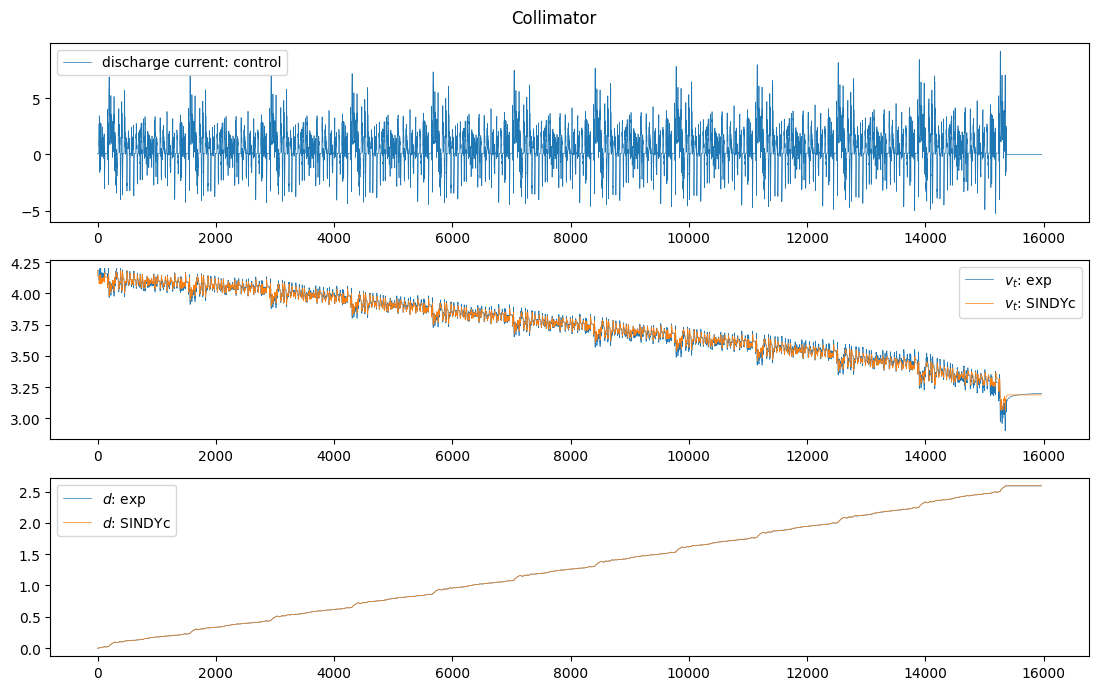

In [11]:
state_data = np.vstack([vt_train, d_train]).T  # exp data for plotting

fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(sol.time, sol.outputs["control"], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[:, i], label=state_names[i] + ": exp", lw=lw)
    ax.plot(
        sol.time, sol.outputs["state"][:, i], label=state_names[i] + ": SINDYc", lw=lw
    )
    ax.legend(loc="best")
fig.suptitle("Collimator")
plt.tight_layout()
plt.show()